In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
import torchvision.models as models
import requests
from PIL import Image
from io import BytesIO
import cv2

In [49]:
def url_to_pil_img(url):
    return Image.open(BytesIO(requests.get(url).content))

imagenet_label_url = "https://files.fast.ai/models/imagenet_class_index.json"


res = requests.get(imagenet_label_url).json()
dictionary = {i:res[str(i)][1] for i in range(len(res))}
pretrained_model = models.vgg16_bn(pretrained=True)
def get_key(label_name):
    for key, val in dictionary.items():
        if val == label_name:
            return key
    return -1


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


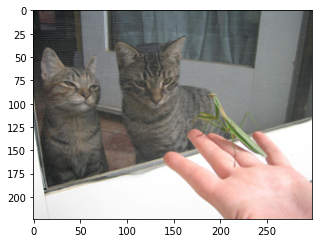

In [87]:
image_url = "https://external-preview.redd.it/Te1zGwSJKlxVL9oIna3oVNI8fodj13K82FmQXq0z_MY.jpg?auto=webp&s=6d002490d63816a676780dc0d8bc317027b67349"
pil_img = url_to_pil_img(image_url)
image_size = (round(pil_img.size[0] * 224 / pil_img.size[1]), 224)
pil_img = pil_img.resize(image_size)

plt.figure(figsize=(5, 5))
plt.imshow(pil_img)
plt.show()

In [88]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.pretrained_model =pretrained_model
        self.forward_cache = []
        self.backward_cache = []
        for layer in self.pretrained_model.modules():
            if isinstance(layer, nn.modules.conv.Conv2d) or isinstance(layer, nn.modules.AdaptiveAvgPool2d):
                layer.register_forward_hook(self.forward_hook)
                layer.register_backward_hook(self.backward_hook)

    def forward(self, x):
        return self.pretrained_model(x)

    def forward_hook(self, module, module_in, model_out):
        self.forward_cache.append(module_in)
        
    def backward_hook(self, module, module_in, module_out):
        self.backward_cache.append(module_in)

    def clear_cache(self):
        self.forward_cache = []
        self.backward_cache = []
    


def load_data():
    data = np.array(pil_img)
    data = np.rollaxis((data - 127.5)/127.5, 2, 0)
    data = torch.from_numpy(data).unsqueeze(0).float()
    data.requires_grad_(True)
    return data

model = CNN()
model.eval()



data = load_data()
y_hat = F.softmax(model(data), dim=-1).squeeze()

probability = y_hat.detach()
args_order = torch.argsort(probability, descending=True).numpy()
for k in range(20):
    print('%20s : %5f'%(dictionary[args_order[k]], probability[args_order[k]]))

        Egyptian_cat : 0.299471
       window_screen : 0.193161
               tabby : 0.175206
           tiger_cat : 0.075616
               quill : 0.026085
              carton : 0.017132
              laptop : 0.015257
                vase : 0.011824
       walking_stick : 0.010682
         paper_towel : 0.007773
    crossword_puzzle : 0.007327
             pitcher : 0.007304
              goblet : 0.006643
         grasshopper : 0.005171
             doormat : 0.005089
               mouse : 0.003795
          table_lamp : 0.003657
           lampshade : 0.003458
        window_shade : 0.003441
             cricket : 0.003410


In [89]:
def grad_cam1(target_layer):    # editted version
    partial = model.backward_cache[len( model.backward_cache) - 1 - target_layer][0].detach().squeeze()
    values = model.forward_cache[target_layer][0].detach().squeeze()
    g_cam = (values * partial).mean(dim=0)
    return F.relu(g_cam)

def grad_cam2(target_layer):    # grad_cam paper version
    partial = model.backward_cache[len( model.backward_cache) - 1 - target_layer][0].detach().squeeze()
    values = model.forward_cache[target_layer][0].detach().squeeze()
    importances = partial.mean(dim=[1, 2]).reshape(-1, 1, 1)
    g_cam = (importances * values).mean(dim=0)
    return F.relu(g_cam)

In [90]:
model.clear_cache()
last_layer = len(model.forward_cache) - 1
data = load_data()
y_hat = F.softmax(model(data), dim=-1).squeeze()
(y_hat[get_key('Egyptian_cat')] +  y_hat[get_key('tiger_cat')]).backward()

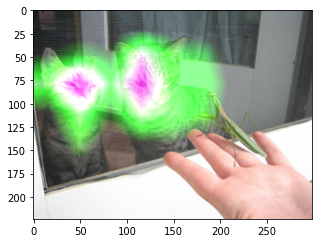

In [91]:
heatmap = grad_cam1(13)
heatmap = heatmap / heatmap.max()
heatmap = np.uint8(heatmap * 255)
heatmap = cv2.resize(heatmap, image_size)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

temp = heatmap
heatmap[:, :, 0] = temp[:, :, 2]
heatmap[:, :, 2] = temp[:, :, 0]
superimposed_img = cv2.addWeighted(np.array(pil_img), 1.0, heatmap, 0.7, 0)
plt.figure(figsize=(5, 5))
plt.imshow(superimposed_img)
plt.show()

In [84]:
# grad_x = np.rollaxis(F.relu(model.backward_cache[13][0]).squeeze().numpy(), 0, 3)
# grad_x = grad_x / grad_x.max()
# plt.figure(figsize=(10, 10))
# plt.imshow(grad_x)
# plt.show()

In [92]:
model.clear_cache()
last_layer = len(model.forward_cache) - 1
data = load_data()
y_hat = F.softmax(model(data), dim=-1).squeeze()
(y_hat[get_key('mantis')] +y_hat[get_key('grasshopper')] + y_hat[get_key('leafhopper')]).backward()

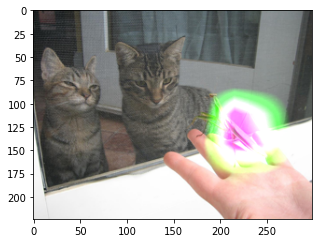

In [93]:
heatmap = grad_cam1(13)
heatmap = heatmap / heatmap.max()
heatmap = np.uint8(heatmap * 255)
heatmap = cv2.resize(heatmap, image_size)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

temp = heatmap
heatmap[:, :, 0] = temp[:, :, 2]
heatmap[:, :, 2] = temp[:, :, 0]
superimposed_img = cv2.addWeighted(np.array(pil_img), 1.0, heatmap, 0.7, 0)
plt.figure(figsize=(5, 5))
plt.imshow(superimposed_img)
plt.show()

In [77]:
# grad_x = np.rollaxis(F.relu(model.backward_cache[13][0]).squeeze().numpy(), 0, 3)
# grad_x = grad_x / grad_x.max()
# plt.figure(figsize=(10, 10))
# plt.imshow(grad_x)
# plt.show()